In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
import time
import scipy.special as special
from scipy.integrate import quad, dblquad, fixed_quad

# Set plot parameters to make beautiful plots
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'large'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'large'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'large'
pl.rcParams['ytick.direction']  = 'in'

In [3]:
# EVERYTHING IS 1 units

#constants
epsilon0  = 1./(4. * np.pi)
e = 4.80320680e-10
m = 9.1093826e-28
c = 2.99792458e10

epsilon  = -1.    #sign of electron charge

#parameters
B       = 1.         #background B strength
n_e     = 1.         #electron number density cm^-3
theta_e = 0.5         #dimensionless electron temp
theta   = np.pi/3.    #observer angle

#derived quantities
omega_p = np.sqrt(n_e * e**2. / (m * epsilon0))     # plasma frequency    (=1 in these units)
omega_c = e * B / (m * c)                           # cyclotron frequency (=1 in these units)

In [184]:
def K_12_prefactor(omega):
    prefactor = - 1. * omega_p**2. / (omega * omega) * 1./(4. * theta_e**2. * special.kn(2, 1./theta_e))
    return prefactor

def K_12_integrand(gamma, cos_xi, tau_prime, omega):    
    prefactor  = 1j
    beta       = np.sqrt(1. - 1./gamma**2.)
    sin_xi     = np.sqrt(1. - cos_xi**2.)
    p_perp_bar = gamma * beta * sin_xi
    p_z_bar    = gamma * beta * cos_xi
    beta_perp  = p_perp_bar / gamma
    beta_z     = p_z_bar    / gamma
    alpha      = beta * np.cos(theta) * tau_prime
    delta      = 2. * omega/(epsilon * omega_c) * np.sin(theta) * gamma * beta * np.sin(
                (epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    
    gamma_term = beta**2. * np.exp(-gamma/theta_e) * np.sin((epsilon * omega_c / omega) * tau_prime / gamma)
    tau_term   = np.exp(1j * tau_prime)
    xi_term    = sin_xi**2. * np.exp(-1j * alpha * cos_xi) * special.j0(delta * sin_xi)
    ans        = prefactor * gamma_term * xi_term * tau_term
    return ans * gamma**2. * beta 

def K_32_prefactor(omega):
    prefactor = omega_p**2. / (omega * omega) * 1./(2. * theta_e**2. * special.kn(2, 1./theta_e))
    return prefactor

def K_32_integrand(gamma, cos_xi, tau_prime, omega):
    prefactor = 1.
    beta       = np.sqrt(1. - 1./gamma**2.)
    sin_xi     = np.sqrt(1. - cos_xi**2.)
    p_perp_bar = gamma * beta * sin_xi
    p_z_bar    = gamma * beta * cos_xi
    beta_perp = p_perp_bar / gamma
    beta_z    = p_z_bar    / gamma
    alpha      = beta * np.cos(theta) * tau_prime
    delta      = 2. * omega/(epsilon * omega_c) * np.sin(theta) * gamma * beta * np.sin(
                (epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    
    gamma_term = beta**2. * np.exp(-gamma/theta_e) * np.sin((epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    tau_term   = np.exp(1j * tau_prime)
    xi_term    = special.jn(1, delta * sin_xi) * (cos_xi * sin_xi) * np.exp(-1j * alpha * cos_xi) 
    ans        = prefactor * gamma_term * tau_term * xi_term
    return ans * gamma**2. * beta

In [200]:
gamma     = 1.5
tau_prime = 1.
omega     = omega_c

def K_12_xi_integrateda(gamma, tau_prime, omega):    
    prefactor  = 1j
    beta       = np.sqrt(1. - 1./gamma**2.)
    alpha      = beta * np.cos(theta) * tau_prime
    delta      = 2. * omega/(epsilon * omega_c) * np.sin(theta) * gamma * beta * np.sin(
                (epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    
    gamma_term = beta**2. * np.exp(-gamma/theta_e) * np.sin((epsilon * omega_c / omega) * tau_prime / gamma)
    tau_term   = np.exp(1j * tau_prime)
    
    if(alpha == 0 or delta == 0):
        return 0.
    
    xi_term    = I_1_analytic(alpha, delta)
    ans        = prefactor * gamma_term * xi_term * tau_term
    return ans * gamma**2. * beta 

def I_1_integrand(x, alpha, delta):
    ans = (1. - x**2.) * np.cos(alpha * x) * special.j0(delta * np.sqrt(1. - x**2.))
    return ans

def I_1_analytic(alpha, delta):
    A     = np.sqrt(alpha**2. + delta**2.)
    minus = np.sqrt(A - alpha)
    plus  = np.sqrt(A + alpha)
    ds    = -np.sign(delta)
    outer = 2. * delta**6. / (alpha**3. * A**5. * minus**7. * plus**7.)
    inner = ((ds*2. * alpha * A**5. * (delta + ds*minus * plus)) * np.cos(alpha)
             + alpha**3. * delta * ds*(2. * alpha**2. - delta**2.) * A * np.cos(A)
             + ds*2. * alpha**4. * delta * A * np.sin(alpha)
             + ds*4. * alpha**2. * delta**3. * A * np.sin(alpha)
             + ds*2. * delta**5. * A * np.sin(alpha)
             + 2. * alpha**4. * A * minus * plus * np.sin(alpha)
             + 4. * alpha**2. * delta**2. * A * minus * plus * np.sin(alpha)
             + 2. * delta**4. * A * minus * plus * np.sin(alpha)
             - ds*alpha**3. * delta * (2. * alpha**2. + (-1. + alpha**2.) * delta**2. + delta**4.) * np.sin(A))
    ans   = outer * inner
    return ans

def K_12_xi_integrated(gamma, tau_prime, omega):
    real_part = quad(lambda cos_xi: K_12_integrand(gamma, cos_xi, tau_prime, omega).real, -1., 1.)
    imag_part = quad(lambda cos_xi: K_12_integrand(gamma, cos_xi, tau_prime, omega).imag, -1., 1.)
    ans       = real_part[0] + 1j * imag_part[0]
    return ans

print quad(lambda cos_xi: K_12_integrand(gamma, cos_xi, tau_prime, omega).imag, -1., 1.)[0]
print K_12_xi_integrateda(gamma, tau_prime, omega).imag

-0.0187707055538
-0.0187707055538


In [201]:
def K_32_xi_term(gamma, cos_xi, tau_prime, omega):
    beta       = np.sqrt(1. - 1./gamma**2.)
    sin_xi     = np.sqrt(1. - cos_xi**2.)
    alpha      = beta * np.cos(theta) * tau_prime
    delta      = 2. * omega/(epsilon * omega_c) * np.sin(theta) * gamma * beta * np.sin(
                (epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    #print alpha, delta
    xi_term    = cos_xi * sin_xi * np.exp(-1j * alpha * cos_xi) * special.jn(1, delta * sin_xi)
    return xi_term

def I_2_integrand(x, alpha, delta):
    ans = x * np.sqrt(1. - x**2.) * np.sin(1 * alpha * x) * special.jn(1, delta * np.sqrt(1. - x**2.))
    return ans

def I_2_analytic(alpha, delta):
    A     = np.sqrt(alpha**2. + delta**2.)
    plus  = np.sqrt(A + alpha)
    minus = np.sqrt(A - alpha)
    num   = alpha * delta**8. * (3. * A * np.cos(A) + (-3. + alpha**2. + delta**2.) * np.sin(A))
    denom = A**5. * minus**7. * plus**7.
    ans   = -num / denom
    return ans

def K_32_xi_integrand_a(gamma, cos_xi, tau_prime, omega):
    prefactor = 1.
    beta       = np.sqrt(1. - 1./gamma**2.)
    sin_xi     = np.sqrt(1. - cos_xi**2.)
    p_perp_bar = gamma * beta * sin_xi
    p_z_bar    = gamma * beta * cos_xi
    beta_perp = p_perp_bar / gamma
    beta_z    = p_z_bar    / gamma
    alpha      = beta * np.cos(theta) * tau_prime
    delta      = 2. * omega/(epsilon * omega_c) * np.sin(theta) * gamma * beta * np.sin(
                (epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    
    gamma_term = beta**2. * np.exp(-gamma/theta_e) * np.sin((epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    tau_term   = np.exp(1j * tau_prime)
    xi_term    = special.jn(1, delta * sin_xi) * (cos_xi * sin_xi) * np.exp(-1j * alpha * cos_xi)
    #xi_term    = I_2_integrand(cos_xi, alpha, delta) * -1j
    ans        = prefactor * gamma_term * tau_term * xi_term
    return ans * gamma**2. * beta

#print quad(lambda cos_xi: K_12_integrand(gamma, cos_xi, tau_prime, omega).real, -1., 1.)
#print quad(lambda cos_xi: K_12_xi_term(gamma, cos_xi, tau_prime, omega).real, -1., 1.)

print (quad(lambda cos_xi: K_32_xi_integrand_a(gamma, cos_xi, tau_prime, omega).real, -1., 1.)[0]+ 
       quad(lambda cos_xi: K_32_xi_integrand_a(gamma, cos_xi, tau_prime, omega).imag, -1., 1.)[0]*1j)
print '-------------------------------------------------'
#print '(-0.0003868078726778312, 0.0002483664788317022)'
print K_32_xi_integrated(gamma, tau_prime, omega)

#print quad(lambda cos_xi: K_32_xi_integrand_a(gamma, cos_xi, tau_prime, omega).imag, -1., 1.)

#print quad(lambda cos_xi: K_32_xi_term(gamma, cos_xi, tau_prime, omega).imag, -1., 1.)[0]
#print quad(lambda x: -I_2_integrand(x, 0.37267799625, 0.633609805829), 0., 1.)[0] * 2.
#print I_2_analytic(0.37267799625, 0.633609805829) * -2.

(-0.000386807872678+0.000248366478832j)
-------------------------------------------------
(-0.000386807872678+0.000248366478832j)


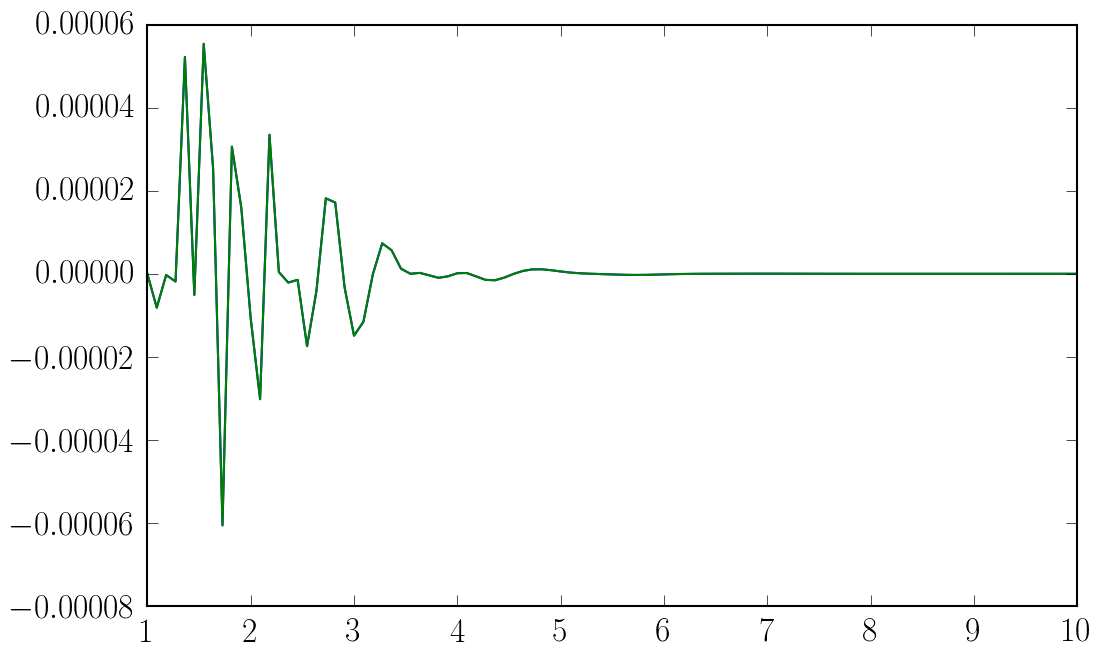

In [202]:
def K_32_xi_integrateda(gamma, tau_prime, omega):
    prefactor = 1.
    beta       = np.sqrt(1. - 1./gamma**2.)
    alpha      = beta * np.cos(theta) * tau_prime
    delta      = 2. * omega/(epsilon * omega_c) * np.sin(theta) * gamma * beta * np.sin(
                (epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    gamma_term = beta**2. * np.exp(-gamma/theta_e) * np.sin((epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    tau_term   = np.exp(1j * tau_prime)
    
    if(alpha == 0 or delta == 0):
        return 0.
    
#    print alpha, delta
    xi_term    = -2j * I_2_analytic(alpha, delta)
    ans        = prefactor * gamma_term * tau_term * xi_term
    
    if(delta < 0):
        #print 'HERE'
        ans = ans * -1.
    
    return ans * gamma**2. * beta

def K_32_xi_integrated(gamma, tau_prime, omega):
    real_part = quad(lambda cos_xi: K_32_integrand(gamma, cos_xi, tau_prime, omega).real, -1., 1.)
    imag_part = quad(lambda cos_xi: K_32_integrand(gamma, cos_xi, tau_prime, omega).imag, -1., 1.)
    ans       = real_part[0] + 1j * imag_part[0]
    return ans

gamma = np.linspace(1., 10., 100)
tau   = 100
omega = omega_c

pl.plot(gamma, np.vectorize(K_12_xi_integrateda)(gamma, tau, omega).real)
pl.plot (gamma, np.vectorize(K_12_xi_integrated)(gamma, tau, omega).real)

In [205]:
def K_32_p_integrated(tau_prime, omega):
    real_part = dblquad(lambda gamma, cos_xi: K_32_integrand(gamma, cos_xi, tau_prime, omega).real, 
                       -1, 1, lambda x: 1., lambda x: np.inf)
    ans = real_part[0]
    return ans

def K_32_p_integrateda(tau_prime, omega):
    real_part = quad(lambda gamma: K_32_xi_integrateda(gamma, tau_prime, omega).real, 1., np.inf)
    ans       = real_part[0]
    return ans

def K_12_p_integrateda(tau_prime, omega):
    real_part = quad(lambda gamma: K_12_xi_integrateda(gamma, tau_prime, omega).real, 1., np.inf)
    ans       = real_part[0]
    return ans

In [208]:
time_before = time.time()
K_12 = fixed_quad(lambda tau: np.vectorize(K_12_p_integrateda)(tau, omega_c), 0., 60., n=55)[0]
K_32 = fixed_quad(lambda tau: np.vectorize(K_32_p_integrateda)(tau, omega_c), 0., 60., n=55)[0]
time_after  = time.time()
print 'time elapsed: ', time_after - time_before

ans = K_12 * K_12_prefactor(omega_c) * np.cos(theta) + K_32 * K_32_prefactor(omega_c) * np.sin(theta)
print 1./c * ans * omega_c

time elapsed:  0.693619012833
-6.50993548029e-10
